# Just Object Classification Demo Project
Here you can go through my demo project that uses VGG-like network. This notebook is just given to demonstrate basic concepts of Object Classification and their implementation using Pytorch.

Importing all necessary packages and modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

We will use a common dataset named `CIFAR10` which consists of 60000 32x32 color images that are equally distributed into 10 classes

In [2]:
from torchvision.datasets import CIFAR10

Hyperparamethers stuff:

In [3]:
BATCH_SIZE = 20
VALIDATION_MULTIPLIER = 0.2
NUM_WORKERS = 0
LEARNING_RATE = 0.01

Then we need to define train, validation and test datasets in order to use them further. 

First of all, we define some basic transformations to make images suitable for our model.

We also divide our entire dataset into a train and a test subsets while initializing dataset objects. Then we split our train set into train and validation and make all necessary `DataLoader`'s

In [4]:
transform = transforms.Compose(
    [transforms.Resize((56,56)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
train_set = CIFAR10(root="./train", train=True, download=True, transform=transform)
test_set = CIFAR10(root="./test", train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def get_train_val_indices(validation_multiplier):
    """Train and validation splitting function."""
    indices = np.arange(len(train_set))
    np.random.shuffle(indices)
    splitting = int(np.floor(validation_multiplier*len(train_set)))
    return (indices[splitting:], indices[:splitting])

In [7]:
def imshow(img):
    """Image displaying function."""
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
train_indices, val_indices = get_train_val_indices(VALIDATION_MULTIPLIER)
print(len(train_indices))
print(len(val_indices))

40000
10000


In [9]:
train_data = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS
)
val_data = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
test_data = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

Let's preview some images from a train dataset

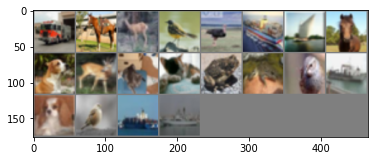

['truck', 'horse', 'deer', 'bird', 'bird', 'ship', 'ship', 'horse', 'dog', 'deer', 'cat', 'cat', 'frog', 'frog', 'bird', 'ship', 'dog', 'bird', 'ship', 'ship']


In [10]:
images, labels = next(iter(train_data))
imshow(torchvision.utils.make_grid(images))
print([classes[i] for i in labels])

We will use `VGG`-like model just because it's complexity allows to easily train it in a small period of time while providing a good enough accuracy for demonstration purposes:

In [11]:
class Net(nn.Module):
    """A VGG-like net that we will use in this demo project."""
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.conv8 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.conv9 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.conv10 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.conv11 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.conv12 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.conv13 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*256, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
#         out = self.conv8(out)
#         out = self.conv9(out)
#         out = self.conv10(out)
#         out = self.conv11(out)
#         out = self.conv12(out)
#         out = self.conv13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [12]:
model = Net()
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

All supporting functions are given below:

In [14]:
def get_accuracy():
    """Func to get accuracy on a validation dataset."""
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for images, labels in val_data:
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predictions == labels).sum().item()
            
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [15]:
def train(num_epochs):
    """Training function."""
    max_accuracy = 0.0
    print("The model will be running on", device, "device")
    model.to(device)
    
    for epoch in range(num_epochs):
        current_loss = 0.0
        current_accuracy = 0.0
        for index, (images, labels) in enumerate(tqdm(train_data), 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            current_loss += loss.item()
            if index % 1000 == 999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {index + 1:5d}] loss: {current_loss / 1000:.3f}')
                current_loss = 0.0
        scheduler.step()
        accuracy = get_accuracy()
        print(f"Epoch: {epoch+1}    Accuracy: {accuracy}")
        
        if accuracy > max_accuracy:
            path = "./model.pth"
            torch.save(model.state_dict(), path)
            max_accuracy = accuracy

In [16]:
def test():
    """Testing function."""
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for images, labels in test_data:
            #images = Variable(images.to(device))
            #labels = Variable(labels.to(device))

#             imshow(torchvision.utils.make_grid(images.cpu()))
            # print("Ground truth: ", ' '.join([classes[labels[idx]] for idx in range(BATCH_SIZE)]))
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            accuracy += (predictions == labels).sum().item()
            # print("Prediction: ", ' '.join([classes[predictions[idx]] for idx in range(BATCH_SIZE)]))
    
    accuracy = (100 * accuracy / total)
    print(accuracy)

Main cell that goes through 5 epochs of training process using a CUDA device

In [17]:
NUM_EPOCHS = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train(NUM_EPOCHS)
print("Training Finished")

The model will be running on cuda:0 device


 40%|████      | 1003/2500 [00:43<00:58, 25.60it/s]

[1,  1000] loss: 1.597


 80%|████████  | 2005/2500 [01:23<00:19, 24.91it/s]

[1,  2000] loss: 1.210


100%|██████████| 2500/2500 [01:42<00:00, 24.44it/s]


Epoch: 1    Accuracy: 62.852


 40%|████      | 1005/2500 [00:40<00:56, 26.48it/s]

[2,  1000] loss: 1.192


 80%|████████  | 2004/2500 [01:18<00:18, 26.42it/s]

[2,  2000] loss: 0.852


100%|██████████| 2500/2500 [01:37<00:00, 25.58it/s]


Epoch: 2    Accuracy: 76.176


 40%|████      | 1005/2500 [00:38<00:56, 26.40it/s]

[3,  1000] loss: 0.653


 80%|████████  | 2004/2500 [01:16<00:18, 26.18it/s]

[3,  2000] loss: 0.630


100%|██████████| 2500/2500 [01:34<00:00, 26.35it/s]


Epoch: 3    Accuracy: 82.158


 40%|████      | 1005/2500 [00:38<00:56, 26.33it/s]

[4,  1000] loss: 0.453


 80%|████████  | 2004/2500 [01:16<00:19, 25.96it/s]

[4,  2000] loss: 0.457


100%|██████████| 2500/2500 [01:34<00:00, 26.34it/s]


Epoch: 4    Accuracy: 90.716


 40%|████      | 1005/2500 [00:37<00:57, 26.10it/s]

[5,  1000] loss: 0.282


 80%|████████  | 2004/2500 [01:15<00:18, 26.57it/s]

[5,  2000] loss: 0.294


100%|██████████| 2500/2500 [01:34<00:00, 26.45it/s]


Epoch: 5    Accuracy: 94.52
Training Finished


After training, we get 94,5% accuracy on a validation set, but of course we still need some testing

In [18]:
model = Net()
model.load_state_dict(torch.load("./model.pth"))
model.eval()
test()

80.08


`80%` accuracy on a training dataset. So far so good, since we used a very light model and performed only 5 epochs of training. 

Thank you!